<a href="https://colab.research.google.com/github/dabandaidai/CSC413/blob/main/project_new_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import tensorflow as tf
from typing import Tuple
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
#from keras.utils import multi_gpu_model

import time, os
import random
import shutil
from math import ceil
import multiprocessing
# Importing required libraries
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM, GRU, Reshape, Concatenate, Bidirectional
from keras.applications.inception_v3 import preprocess_input
from keras.layers import GaussianNoise
from keras.callbacks import Callback, TensorBoard
import pickle
import sys
import warnings

## Read in data

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"naihexiao","key":"dc003e05b496db6674191ae798c58498"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gpreda/chinese-mnist

100% 16.5M/16.5M [00:01<00:00, 18.5MB/s]
100% 16.5M/16.5M [00:01<00:00, 9.67MB/s]


In [ ]:
!unzip chinese-mnist

Streaming output truncated to the last 5000 lines.
  inflating: data/data/input_6_6_5.jpg  
  inflating: data/data/input_6_6_6.jpg  
  inflating: data/data/input_6_6_7.jpg  
  inflating: data/data/input_6_6_8.jpg  
  inflating: data/data/input_6_6_9.jpg  
  inflating: data/data/input_6_7_1.jpg  
  inflating: data/data/input_6_7_10.jpg  
  inflating: data/data/input_6_7_11.jpg  
  inflating: data/data/input_6_7_12.jpg  
  inflating: data/data/input_6_7_13.jpg  
  inflating: data/data/input_6_7_14.jpg  
  inflating: data/data/input_6_7_15.jpg  
  inflating: data/data/input_6_7_2.jpg  
  inflating: data/data/input_6_7_3.jpg  
  inflating: data/data/input_6_7_4.jpg  
  inflating: data/data/input_6_7_5.jpg  
  inflating: data/data/input_6_7_6.jpg  
  inflating: data/data/input_6_7_7.jpg  
  inflating: data/data/input_6_7_8.jpg  
  inflating: data/data/input_6_7_9.jpg  
  inflating: data/data/input_6_8_1.jpg  
  inflating: data/data/input_6_8_10.jpg  
  inflating: data/data/input_6_8_11.jpg 

In [ ]:
# chinese_mnist_df.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
data = pd.read_csv('chinese_mnist.csv', delimiter=',')
data.dataframeName = 'chinese_mnist_df.csv'
nRow, nCol = data.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 15000 rows and 5 columns


In [ ]:
data.loc[(data['suite_id'] == 100) & (data['sample_id'] == 10) & (data['code'] == 10)]

,suite_id,sample_id,code,value,character
21,100,10,10,9,九


## Reshape images and prepare train, validation, test sets.

In [ ]:
labels = np.array([ x - 1 for x in data['code'].values ])
images = np.array([ cv2.resize(cv2.imread(f"/content/data/data/input_{suite_id}_{sample_id}_{code}.jpg", cv2.IMREAD_GRAYSCALE), (299, 299)) for suite_id, sample_id, code in data[['suite_id', 'sample_id', 'code']].values ])
indices = np.arange(len(images))
np.random.seed(413) 
np.random.shuffle(indices)
splited_indices = np.split(indices, [int(images.shape[0] * 0.6), int(images.shape[0] * 0.7)])
training_images, training_labels, validation_images, validation_labels, test_images, test_labels = \
          (images[splited_indices[0]], labels[splited_indices[0]], 
          images[splited_indices[1]], labels[splited_indices[1]], 
          images[splited_indices[2]], labels[splited_indices[2]])

In [ ]:
print(training_images.shape)
print(training_labels.shape)
print(validation_images.shape)
print(validation_labels.shape)
print(test_images.shape)
print(test_labels.shape)
assert(training_images.shape[0] + validation_images.shape[0] + test_images.shape[0] == 15000)

(9000, 299, 299)
(9000,)
(1500, 299, 299)
(1500,)
(4500, 299, 299)
(4500,)


## Full images stored at 2 folders


In [ ]:
# Create a directory to save the training images
if not os.path.exists('train_full'):
    os.makedirs('train_full')
# Create a directory to save the test images
if not os.path.exists('test_full'):
    os.makedirs('test_full')

# Save the test images to the directory
for i, image in enumerate(test_images):
    filename = f'test_full/image_{i}.jpg'
    cv2.imwrite(filename, image)

# Create subdirectories for each class
for i in range(15):
    if not os.path.exists(f'train_full/class_{i+1}'):
        os.makedirs(f'train_full/class_{i+1}')

# Move images to their respective class subdirectories
for i, image in enumerate(training_images):
    class_num = training_labels[i] + 1
    filename = f'train_full/class_{class_num}/image_{i}.jpg'
    cv2.imwrite(filename, image)

## Utility functions

In [ ]:
def dataloader_generator(train_path, data_size, dataset_type):
    """ Loads data """
    # set the random seed
    random.seed(413)

    train_set_filename = dataset_type + "_train_set"
    val_set_filename = dataset_type + "_val_set"

    # create directories to store the new training and validation sets
    if not os.path.exists(train_set_filename):
        os.makedirs(train_set_filename)

    # loop through each class in the original training and validation sets
    for class_num in range(1, 16):
        
        # create a directory to store the new subset of the class
        if not os.path.exists(f'{train_set_filename}/class_{class_num}'):
            os.makedirs(f'{train_set_filename}/class_{class_num}')
        if not os.path.exists(f'{val_set_filename}/class_{class_num}'):
            os.makedirs(f'{val_set_filename}/class_{class_num}')
        
        # randomly select data_size samples from the original training and validation sets for the current class
        class_samples = random.sample(os.listdir(os.path.join(train_path, f'class_{class_num}')), data_size)

        # randomly select 20% of the samples for validation and the rest for training
        num_samples = len(class_samples)
        num_val_samples = int(0.2*num_samples)
        num_train_samples = num_samples - num_val_samples

        val_class_samples = random.sample(class_samples, num_val_samples)
        train_class_samples = list(set(class_samples) - set(val_class_samples))

        # move the training samples to the new training directory
        for sample in train_class_samples:
            image = cv2.imread(os.path.join(train_path, f'class_{class_num}', sample))
            filename = f'{train_set_filename}/class_{class_num}/{sample}'
            cv2.imwrite(filename, image)

        # move the validation samples to the new validation directory
        for sample in val_class_samples:
            image = cv2.imread(os.path.join(train_path, f'class_{class_num}', sample))
            filename = f'{val_set_filename}/class_{class_num}/{sample}'
            cv2.imwrite(filename, image)

    # create the data generators for the new training and validation sets
    train_generator = train_datagen.flow_from_directory(train_set_filename,
                                                  target_size=(299, 299),
                                                  batch_size=50,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=7)

    val_generator = train_datagen.flow_from_directory(val_set_filename,
                                                target_size=(299, 299),
                                                batch_size=50,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=7)
    return train_generator, val_generator

In [ ]:
## fix for multi_gpu_model prediction time longer
from keras.layers import Lambda, concatenate
from keras import Model
import tensorflow as tf

def multi_gpu_model(model, gpus):
    if isinstance(gpus, (list, tuple)):
        num_gpus = len(gpus)
        target_gpu_ids = gpus
    else:
        num_gpus = gpus
        target_gpu_ids = range(num_gpus)

    def get_slice(data, i, parts):
        shape = tf.shape(data)
        batch_size = shape[:1]
        input_shape = shape[1:]
        step = batch_size // parts
        if i == num_gpus - 1:
            size = batch_size - step * i
        else:
            size = step
        size = tf.concat([size, input_shape], axis=0)
        stride = tf.concat([step, input_shape * 0], axis=0)
        start = stride * i
        return tf.slice(data, start, size)

    all_outputs = []
    for i in range(len(model.outputs)):
        all_outputs.append([])

    # Place a copy of the model on each GPU,
    # each getting a slice of the inputs.
    
    # This part of the code places a copy of the original model on each GPU 
    # device specified by target_gpu_ids, and slices the inputs among the GPUs. 
    # The for loop goes through each GPU device and retrieves a slice of input 
    # for that particular GPU. The model is then applied to the sliced input, 
    # and the outputs are saved for merging back together later.
    for i, gpu_id in enumerate(target_gpu_ids):
        with tf.device('/gpu:%d' % gpu_id):
            with tf.name_scope('replica_%d' % gpu_id):
                inputs = []
                # Retrieve a slice of the input.
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_i = Lambda(get_slice,
                                   output_shape=input_shape,
                                   arguments={'i': i,
                                              'parts': num_gpus})(x)
                    inputs.append(slice_i)

                # Apply model on slice
                # (creating a model replica on the target device).
                outputs = model(inputs)
                if not isinstance(outputs, list):
                    outputs = [outputs]

                # Save the outputs for merging back together later.
                for o in range(len(outputs)):
                    all_outputs[o].append(outputs[o])

    # Merge outputs on CPU.
    with tf.device('/cpu:0'):
        merged = []
        for name, outputs in zip(model.output_names, all_outputs):
            merged.append(concatenate(outputs,
                                    axis=0, name=name))
        return Model(model.inputs, merged)


In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def create_dir_if_not_exists(directory):
    """Creates a directory if it doesn't already exist."""
    if not os.path.exists(directory):
        os.makedirs(directory)

def print_opts(opts):
    """Prints the values of all command-line arguments."""
    print("=" * 80)
    print("Opts".center(80))
    print("-" * 80)
    for key in opts.__dict__:
        print("{:>30}: {:<30}".format(key, opts.__dict__[key]).center(80))
    print("=" * 80)

In [ ]:
def freeze(model: tf.keras.Model):
    """Freeze a number of layers in the model."""
    for layer in model.layers:
        layer.trainable = False

## Dataloader

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function=preprocess_input
)


In [ ]:
# set the path to the original training and validation sets
train_path = 'train_full'
val_path = 'test_full'
BATCH_SIZE = 50

small_train_set, small_val_set = dataloader_generator(train_path, 50, "small", )
median_train_set, median_val_set = dataloader_generator(train_path, 100, "median", )
large_train_set, large_val_set = dataloader_generator(train_path, 200, "large")

Found 600 images belonging to 15 classes.
Found 150 images belonging to 15 classes.
Found 1200 images belonging to 15 classes.
Found 300 images belonging to 15 classes.
Found 2400 images belonging to 15 classes.
Found 600 images belonging to 15 classes.


In [ ]:
ls small_train_set/class_6

image_1097.jpg  image_1837.jpg  image_4197.jpg  image_6108.jpg  image_7648.jpg
image_1182.jpg  image_183.jpg   image_4451.jpg  image_613.jpg   image_7875.jpg
image_1210.jpg  image_2051.jpg  image_4697.jpg  image_6841.jpg  image_7942.jpg
image_1242.jpg  image_2207.jpg  image_5063.jpg  image_6969.jpg  image_7983.jpg
image_1487.jpg  image_2579.jpg  image_5082.jpg  image_716.jpg   image_8040.jpg
image_150.jpg   image_2592.jpg  image_582.jpg   image_7278.jpg  image_8071.jpg
image_1656.jpg  image_2659.jpg  image_594.jpg   image_748.jpg   image_8671.jpg
image_175.jpg   image_3.jpg     image_6081.jpg  image_7579.jpg  image_8873.jpg


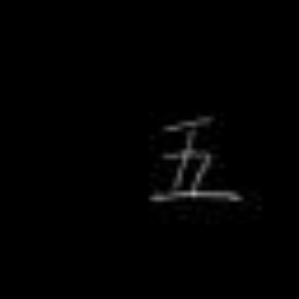

In [ ]:
from IPython.display import Image, display
display(Image('small_train_set/class_6/image_2579.jpg'))

## Inception V3

In [ ]:
#MUL 1 - Inception - ST

# Loading InceptionV3 model with ImageNet weights and removing top layer
f1_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))
f1_x = f1_base.output

# Adding Global Average Pooling layer
f1_x = GlobalAveragePooling2D()(f1_x)

# Reshaping the tensor
f1_x = Reshape([1,2048])(f1_x)  

# Adding GRU layer
f1_x = GRU(2048, 
            return_sequences=False,                       
            dropout=0.8                                     
            input_shape=[1,2048])(f1_x)

# Adding Gaussian noise layer for regularization
f1_x = GaussianNoise(0.1)(f1_x)

# Adding Dense layer with 1024 units and ReLU activation function
f1_x = Dense(1024, activation='relu')(f1_x)

# Adding Dense layer with 10 units and softmax activation function
f1_x = Dense(15, activation='softmax')(f1_x)

# Creating the final model
model = Model(inputs=[f1_base.input],outputs=[f1_x])

# Printing the summary of the model
# print(model_1.summary())

87910968/87910968 [==============================] - 5s 0us/step


## Train and evaluate

In [ ]:
def train_evaluate(model, opts, train_dataset, val_dataset):
    # Using multiple models if more than 1 GPU
    if opts.gpus != 1:
        model_mul = multi_gpu_model(model, opts.gpus)
    else:
        model_mul = model

    #### setup checkpoint path
    model_name = "Inception3-GRU-bs{}-t{}-v{}".format(
        opts.batch_size, opts.train_data_set, opts.val_data_set
    )
    opts.checkpoint_path = model_name
    create_dir_if_not_exists(opts.checkpoint_path)
    ####
      
    epochs = opts.nepochs
    learning_rate = opts.learning_rate
    decay = learning_rate/epochs
    optimizer = Adam(lr=learning_rate, decay=decay)

    model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
        TensorBoard(log_dir='./logs')
    ]

    STEP_SIZE_TRAIN=train_dataset.n//train_dataset.batch_size
    STEP_SIZE_VALID=val_dataset.n//val_dataset.batch_size

    train_history = model_mul.fit(
      train_dataset,
      steps_per_epoch=STEP_SIZE_TRAIN,
      validation_data=train_dataset,
      validation_steps=STEP_SIZE_VALID,
      epochs=epochs,
      #callbacks=[earlystopping],
      verbose=1,
      callbacks=callbacks
    )

    return train_history




In [ ]:
freeze(f1_base)

In [ ]:
trans32_args_s = AttrDict()
args_dict = {
    "train_data_set": "small_train_set",
    "val_data_set": "small_val_set",
    "gpus": 1,
    "nepochs": 50,
    "learning_rate": 1e-4,
    # "early_stopping_patience": 100,
    # "lr_decay": 0.99,
    "batch_size": 100,
    # "hidden_size": 32,
}

trans32_args_s.update(args_dict)

print_opts(trans32_args_s)

history = train_evaluate(model, trans32_args_s, small_train_set, small_val_set)


                                      Opts                                      
--------------------------------------------------------------------------------
                         train_data_set: small_train_set                        
                           val_data_set: small_val_set                          
                                   gpus: 4                                      
                                nepochs: 50                                     
                          learning_rate: 0.0001                                 
                             batch_size: 100                                    
Epoch 1/50
12/12 [==============================] - 46s 2s/step - loss: 15.0436 - accuracy: 0.0667 - val_loss: 15.3659 - val_accuracy: 0.0467
Epoch 2/50
10/12 [========================>.....] - ETA: 2s - loss: 15.0221 - accuracy: 0.0680

KeyboardInterrupt: ignored

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
trans32_args_s = AttrDict()
args_dict = {
    "train_data_set": "median_train_set",
    "val_data_set": "median_val_set",
    "gpus": 4,
    "nepochs": 50,
    "learning_rate": 1e-4,
    # "early_stopping_patience": 100,
    # "lr_decay": 0.99,
    "batch_size": 50,
    # "hidden_size": 32,
}

trans32_args_s.update(args_dict)

print_opts(trans32_args_s)

train_evaluate(model, trans32_args_s, median_train_set, median_val_set)


                                      Opts                                      
--------------------------------------------------------------------------------
                         train_data_set: median_train_set                       
                           val_data_set: median_val_set                         
                                   gpus: 4                                      
                                nepochs: 50                                     
                          learning_rate: 0.0001                                 
                             batch_size: 50                                     
Epoch 1/50
 6/38 [===>..........................] - ETA: 28s - loss: 2.9116 - accuracy: 0.0625

KeyboardInterrupt: ignored

In [ ]:
trans32_args_s = AttrDict()
args_dict = {
    "train_data_set": "large_train_set",
    "val_data_set": "large_val_set",
    "gpus": 4,
    "nepochs": 50,
    "learning_rate": 1e-4,
    # "early_stopping_patience": 100,
    # "lr_decay": 0.99,
    "batch_size": 50,
    # "hidden_size": 32,
}

trans32_args_s.update(args_dict)

print_opts(trans32_args_s)

train_evaluate(model, trans32_args_s, large_train_set, large_val_set)


                                      Opts                                      
--------------------------------------------------------------------------------
                         train_data_set: large_train_set                        
                           val_data_set: large_val_set                          
                                   gpus: 4                                      
                                nepochs: 50                                     
                          learning_rate: 0.0001                                 
                             batch_size: 50                                     
Epoch 1/50
48/48 [==============================] - 119s 2s/step - loss: 15.0436 - accuracy: 0.0667 - val_loss: 14.8824 - val_accuracy: 0.0767
Epoch 2/50
48/48 [==============================] - 76s 2s/step - loss: 15.0436 - accuracy: 0.0667 - val_loss: 15.0973 - val_accuracy: 0.0633
Epoch 3/50
28/48 [================>.............] - ETA: 22s - loss

KeyboardInterrupt: ignored